In [1]:
using Revise

includet("./modules/RidgeRegression.jl")
includet("./modules/Experiments.jl")
includet("./modules/Replica.jl")

using .RidgeRegression: solve_rr
using .Experiments: generate_data, convert_to_vec, calc_generalization_error, calc_orderparams
using .Replica: solve_replica
using Distributions, Random, Statistics, CairoMakie, LinearAlgebra

## Parameters

In [2]:
α = 2.3
τ = 1.7   # \tau = \gamma * \kappa
κs = [0.25, 0.5, 1.0, 1.5, 2.0]
σ = 0.003
λ = 3.0
ρ = 0.2
num_trials = 10

10

## Simulation

In [3]:
D = 70
r = round(Int, D * ρ)
L = round(Int, D * α)
M = round(Int, D^2 * τ)


Q_sims = zeros(length(κs), num_trials)
m_sims = zeros(length(κs), num_trials)
Q_bar_sims = zeros(length(κs), num_trials)
m_bar_sims = zeros(length(κs), num_trials)
Q0_sims = zeros(length(κs), num_trials)
m0_sims = zeros(length(κs), num_trials)

@time @Threads.threads for ind in CartesianIndices(Q_sims)
    i, j = Tuple(ind)
    κ = κs[i]
    local_rng = MersenneTwister(12433784 + 1000i + j)
    local_rng_new = MersenneTwister(722525 + 1000i + j)

    # generate pretraining data
    M0 = round(Int, D * κ)
    X, W0, W, Y, H, A = generate_data(D, L, M, M0, σ, r, rng=local_rng)
    vecH = convert_to_vec(H)

    # solve ridge regression
    vec_Γ = solve_rr(vecH, Y[:, end], bias=false, lambda = λ * M0, mean_loss=false)
    Γ = reshape(vec_Γ, D, D)

    # calc experimental orderparams
    Q_sim, m_sim, Q_bar_sim, m_bar_sim, Q0_sim, m0_sim = calc_orderparams(W0, Γ, A=A, r=r)
    Q_sims[i, j] = Q_sim
    m_sims[i, j] = m_sim
    Q_bar_sims[i, j] = Q_bar_sim
    m_bar_sims[i, j] = m_bar_sim
    Q0_sims[i, j] = Q0_sim
    m0_sims[i, j] = m0_sim
end



 45.230301 seconds (286.72 M allocations: 222.443 GiB, 36.32% gc time, 699.54% compilation time)


## Replica Theory

In [4]:
κs_theory = range(0.1, 2.0, length=200)
Q_theory = zeros(length(κs_theory))
m_theory = zeros(length(κs_theory))
Q_bar_theory = zeros(length(κs_theory))
m_bar_theory = zeros(length(κs_theory))
Q0_theory = zeros(length(κs_theory))
m0_theory = zeros(length(κs_theory))

for (i, κ) in enumerate(κs_theory)
    q, m, χ, q_bar, χ_bar, q̂, m̂, χ̂, q̂_bar, χ̂_bar, m_bar, q0, m0 = solve_replica(α, τ, κ, λ, σ, ρ, damp=0.7, tol=1e-7)
    Q_theory[i] = q
    m_theory[i] = m
    Q_bar_theory[i] = q_bar
    m_bar_theory[i] = m_bar 
    Q0_theory[i] = q0
    m0_theory[i] = m0
end

## Plotting

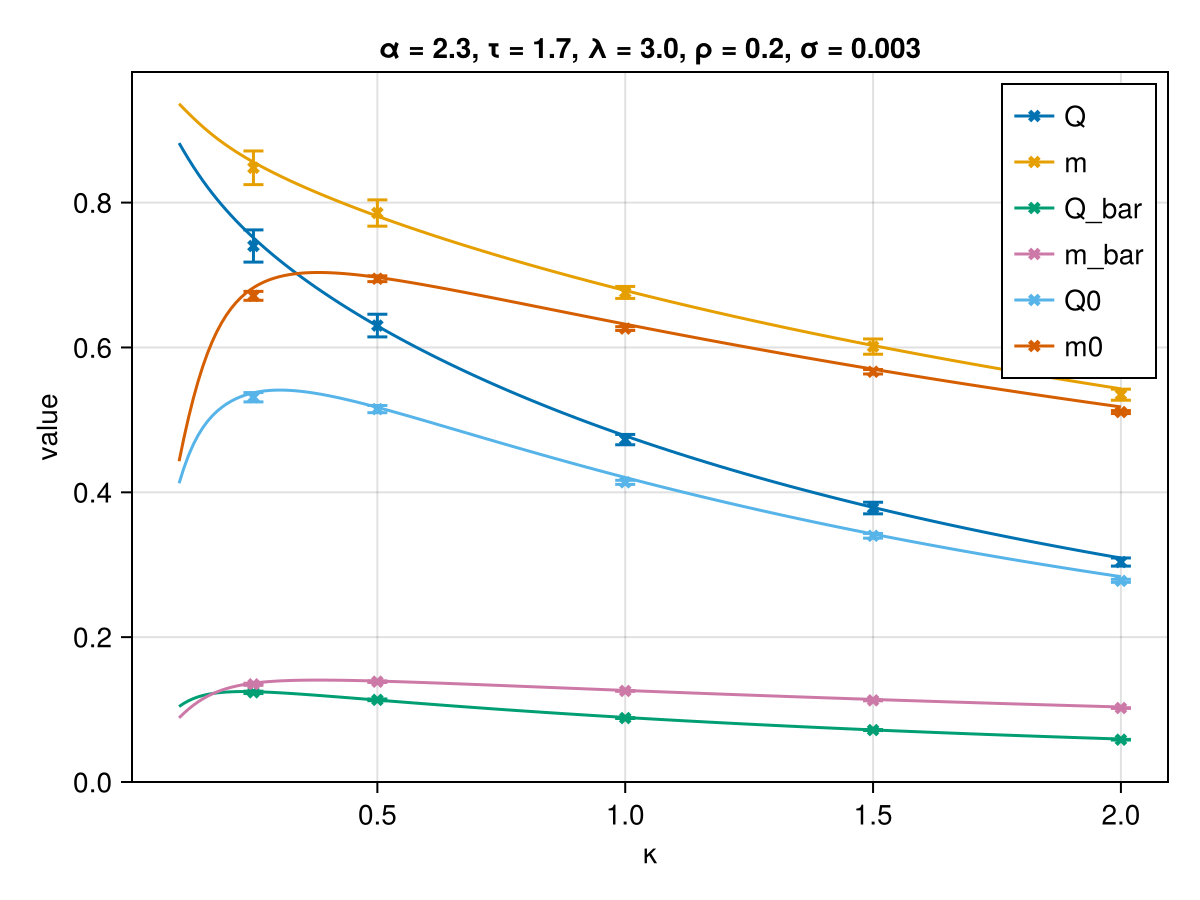

CairoMakie.Screen{IMAGE}


In [5]:
fig = Figure()
ax = Axis(fig[1, 1], limits=(nothing, nothing, 0.0, nothing),
    xlabel="κ", ylabel="value", title="α = $α, τ = $τ, λ = $λ, ρ = $ρ, σ = $σ")

# plot theory results
lines!(ax, κs_theory, Q_theory, label="Q")
lines!(ax, κs_theory, m_theory, label="m")
lines!(ax, κs_theory, Q_bar_theory, label="Q_bar")
lines!(ax, κs_theory, m_bar_theory, label="m_bar")
lines!(ax, κs_theory, Q0_theory, label="Q0")
lines!(ax, κs_theory, m0_theory, label="m0")

# plot simulation results (mean and error bars)
scatter!(ax, κs, vec(mean(Q_sims, dims=2)), label="Q", marker=:x)
scatter!(ax, κs, vec(mean(m_sims, dims=2)), label="m", marker=:x)
scatter!(ax, κs, vec(mean(Q_bar_sims, dims=2)), label="Q_bar", marker=:x)
scatter!(ax, κs, vec(mean(m_bar_sims, dims=2)), label="m_bar", marker=:x)
scatter!(ax, κs, vec(mean(Q0_sims, dims=2)), label="Q0", marker=:x)
scatter!(ax, κs, vec(mean(m0_sims, dims=2)), label="m0", marker=:x)
errorbars!(ax, κs, vec(mean(Q_sims, dims=2)), vec(std(Q_sims, dims=2) ./ sqrt(num_trials)), whiskerwidth=10)
errorbars!(ax, κs, vec(mean(m_sims, dims=2)), vec(std(m_sims, dims=2) ./ sqrt(num_trials)), whiskerwidth=10)
errorbars!(ax, κs, vec(mean(Q_bar_sims, dims=2)), vec(std(Q_bar_sims, dims=2) ./ sqrt(num_trials)), whiskerwidth=10)
errorbars!(ax, κs, vec(mean(m_bar_sims, dims=2)), vec(std(m_bar_sims, dims=2) ./ sqrt(num_trials)), whiskerwidth=10)
errorbars!(ax, κs, vec(mean(Q0_sims, dims=2)), vec(std(Q0_sims, dims=2) ./ sqrt(num_trials)), whiskerwidth=10)
errorbars!(ax, κs, vec(mean(m0_sims, dims=2)), vec(std(m0_sims, dims=2) ./ sqrt(num_trials)), whiskerwidth=10)


axislegend(ax, position=:rt, merge=true)
display(fig)